In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE3_TSNE2.pth'


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states(TSNE2)/reference embeddings
from sklearn.manifold import TSNE
# 处理 hidden states 的函数
def extract_hidden_states(texts, model, tokenizer, apply_tsne=True, n_components=3, batch_size=128):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_state = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()  # 提取最后一层的 hidden states
        hidden_states.append(hidden_state)

    hidden_states = np.vstack(hidden_states)
    
    # 应用 t-SNE
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        hidden_states = tsne.fit_transform(hidden_states)
        print(f"Hidden states reduced to {n_components} dimensions using t-SNE.")
        
    return hidden_states

# 处理 reference embeddings 的函数
def extract_reference_embeddings(references, model, tokenizer, apply_tsne=True, n_components=2, batch_size=128):
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())  # 提取池化后的输出

    embeddings = np.vstack(embeddings)
    
    # 应用 t-SNE
    if apply_tsne:
        tsne = TSNE(n_components=n_components, random_state=42)
        embeddings = tsne.fit_transform(embeddings)
        print(f"Reference embeddings reduced to {n_components} dimensions using t-SNE.")
    
    return embeddings

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    
    return custom_mlp, losses, best_accuracy

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]
/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 12/12 [40:16<00:00, 201.39s/it] 
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Hidden states reduced to 3 dimensions using t-SNE.
Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 12/12 [02:02<00:00, 10.17s/it]


Reference embeddings reduced to 2 dimensions using t-SNE.
Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 12/12 [36:33<00:00, 182.83s/it] 


Hidden states reduced to 3 dimensions using t-SNE.
Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 12/12 [01:34<00:00,  7.90s/it]


Reference embeddings reduced to 2 dimensions using t-SNE.


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=5 and hidden_dim=256


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epochs:   2%|▏         | 9/500 [00:02<02:17,  3.57it/s]

Epoch 10/500, Loss: 15.6466


Training Epochs:   2%|▏         | 10/500 [00:03<03:09,  2.58it/s]

Test Accuracy at Epoch 10: 52.50%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.51      0.46      0.49       283
non_infringement       0.53      0.59      0.56       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581

New best model saved with accuracy 52.50% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.51      0.46      0.49       283
non_infringement       0.53      0.59      0.56       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:   4%|▍         | 20/500 [00:06<02:52,  2.79it/s]

Epoch 20/500, Loss: 10.1840
Test Accuracy at Epoch 20: 46.47%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.45      0.43      0.44       283
non_infringement       0.48      0.50      0.49       298

        accuracy                           0.46       581
       macro avg       0.46      0.46      0.46       581
    weighted avg       0.46      0.46      0.46       581



Training Epochs:   6%|▌         | 30/500 [00:09<02:26,  3.20it/s]

Epoch 30/500, Loss: 6.2934
Test Accuracy at Epoch 30: 45.96%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.45      0.47      0.46       283
non_infringement       0.47      0.45      0.46       298

        accuracy                           0.46       581
       macro avg       0.46      0.46      0.46       581
    weighted avg       0.46      0.46      0.46       581



Training Epochs:   8%|▊         | 40/500 [00:13<03:16,  2.34it/s]

Epoch 40/500, Loss: 4.5519
Test Accuracy at Epoch 40: 44.41%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.43      0.45      0.44       283
non_infringement       0.46      0.44      0.45       298

        accuracy                           0.44       581
       macro avg       0.44      0.44      0.44       581
    weighted avg       0.44      0.44      0.44       581



Training Epochs:  10%|█         | 51/500 [00:15<00:54,  8.27it/s]

Epoch 50/500, Loss: 3.0979
Test Accuracy at Epoch 50: 42.17%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.40      0.35      0.37       283
non_infringement       0.44      0.49      0.46       298

        accuracy                           0.42       581
       macro avg       0.42      0.42      0.42       581
    weighted avg       0.42      0.42      0.42       581



Training Epochs:  12%|█▏        | 60/500 [00:18<02:19,  3.15it/s]

Epoch 60/500, Loss: 2.2979
Test Accuracy at Epoch 60: 45.27%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.44      0.42      0.43       283
non_infringement       0.47      0.48      0.48       298

        accuracy                           0.45       581
       macro avg       0.45      0.45      0.45       581
    weighted avg       0.45      0.45      0.45       581



Training Epochs:  14%|█▍        | 70/500 [00:20<01:16,  5.61it/s]

Epoch 70/500, Loss: 1.8376
Test Accuracy at Epoch 70: 48.19%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.47      0.48      0.48       283
non_infringement       0.49      0.48      0.49       298

        accuracy                           0.48       581
       macro avg       0.48      0.48      0.48       581
    weighted avg       0.48      0.48      0.48       581



Training Epochs:  16%|█▌        | 80/500 [00:21<00:27, 15.51it/s]

Epoch 80/500, Loss: 1.5436
Test Accuracy at Epoch 80: 51.81%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.51      0.50      0.50       283
non_infringement       0.53      0.53      0.53       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  18%|█▊        | 90/500 [00:21<00:21, 18.75it/s]

Epoch 90/500, Loss: 1.3108
Test Accuracy at Epoch 90: 50.95%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.50      0.49      0.50       283
non_infringement       0.52      0.52      0.52       298

        accuracy                           0.51       581
       macro avg       0.51      0.51      0.51       581
    weighted avg       0.51      0.51      0.51       581



Training Epochs:  20%|██        | 100/500 [00:23<01:25,  4.67it/s]

Epoch 100/500, Loss: 1.1449
Test Accuracy at Epoch 100: 50.95%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.50      0.49      0.49       283
non_infringement       0.52      0.53      0.52       298

        accuracy                           0.51       581
       macro avg       0.51      0.51      0.51       581
    weighted avg       0.51      0.51      0.51       581



Training Epochs:  22%|██▏       | 110/500 [00:27<02:23,  2.71it/s]

Epoch 110/500, Loss: 1.0067
Test Accuracy at Epoch 110: 51.98%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.51      0.50      0.50       283
non_infringement       0.53      0.54      0.54       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  24%|██▍       | 121/500 [00:30<01:16,  4.94it/s]

Epoch 120/500, Loss: 0.8914
Test Accuracy at Epoch 120: 52.50%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.51      0.50      0.51       283
non_infringement       0.54      0.55      0.54       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  26%|██▌       | 130/500 [00:33<02:13,  2.76it/s]

Epoch 130/500, Loss: 0.7931
Test Accuracy at Epoch 130: 54.56%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.53      0.54      0.54       283
non_infringement       0.56      0.55      0.55       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

New best model saved with accuracy 54.56% at epoch 130
Best Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.53      0.54      0.54       283
non_infringement       0.56      0.55      0.55       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:  28%|██▊       | 140/500 [00:37<02:23,  2.51it/s]

Epoch 140/500, Loss: 0.7101
Test Accuracy at Epoch 140: 53.70%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.52      0.53      0.53       283
non_infringement       0.55      0.54      0.54       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581



Training Epochs:  30%|███       | 150/500 [00:40<01:50,  3.16it/s]

Epoch 150/500, Loss: 0.6400
Test Accuracy at Epoch 150: 52.84%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.52      0.53      0.52       283
non_infringement       0.54      0.52      0.53       298

        accuracy                           0.53       581
       macro avg       0.53      0.53      0.53       581
    weighted avg       0.53      0.53      0.53       581



Training Epochs:  32%|███▏      | 160/500 [00:43<01:52,  3.04it/s]

Epoch 160/500, Loss: 0.5787
Test Accuracy at Epoch 160: 51.64%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.50      0.52      0.51       283
non_infringement       0.53      0.51      0.52       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  34%|███▍      | 170/500 [00:43<00:22, 14.96it/s]

Epoch 170/500, Loss: 0.5232
Test Accuracy at Epoch 170: 50.95%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.50      0.51      0.50       283
non_infringement       0.52      0.51      0.51       298

        accuracy                           0.51       581
       macro avg       0.51      0.51      0.51       581
    weighted avg       0.51      0.51      0.51       581



Training Epochs:  36%|███▌      | 179/500 [00:44<00:40,  7.90it/s]

Epoch 180/500, Loss: 0.4724
Test Accuracy at Epoch 180: 50.43%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.49      0.51      0.50       283
non_infringement       0.52      0.50      0.51       298

        accuracy                           0.50       581
       macro avg       0.50      0.50      0.50       581
    weighted avg       0.50      0.50      0.50       581



Training Epochs:  38%|███▊      | 190/500 [00:46<00:45,  6.80it/s]

Epoch 190/500, Loss: 0.4262
Test Accuracy at Epoch 190: 49.23%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.48      0.48      0.48       283
non_infringement       0.51      0.51      0.51       298

        accuracy                           0.49       581
       macro avg       0.49      0.49      0.49       581
    weighted avg       0.49      0.49      0.49       581



Training Epochs:  40%|████      | 200/500 [00:49<01:24,  3.54it/s]

Epoch 200/500, Loss: 0.3853
Test Accuracy at Epoch 200: 50.26%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.49      0.47      0.48       283
non_infringement       0.51      0.53      0.52       298

        accuracy                           0.50       581
       macro avg       0.50      0.50      0.50       581
    weighted avg       0.50      0.50      0.50       581



Training Epochs:  42%|████▏     | 211/500 [00:50<00:38,  7.59it/s]

Epoch 210/500, Loss: 0.3502
Test Accuracy at Epoch 210: 50.60%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.49      0.47      0.48       283
non_infringement       0.52      0.54      0.53       298

        accuracy                           0.51       581
       macro avg       0.51      0.51      0.51       581
    weighted avg       0.51      0.51      0.51       581



Training Epochs:  44%|████▍     | 219/500 [00:50<00:15, 17.81it/s]

Epoch 220/500, Loss: 0.3205
Test Accuracy at Epoch 220: 50.77%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.49      0.48      0.49       283
non_infringement       0.52      0.54      0.53       298

        accuracy                           0.51       581
       macro avg       0.51      0.51      0.51       581
    weighted avg       0.51      0.51      0.51       581



Training Epochs:  46%|████▋     | 232/500 [00:52<00:19, 13.62it/s]

Epoch 230/500, Loss: 0.2956
Test Accuracy at Epoch 230: 51.64%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.50      0.49      0.50       283
non_infringement       0.53      0.54      0.53       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  48%|████▊     | 240/500 [00:54<01:15,  3.46it/s]

Epoch 240/500, Loss: 0.2744
Test Accuracy at Epoch 240: 51.98%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.51      0.50      0.50       283
non_infringement       0.53      0.54      0.53       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  50%|█████     | 250/500 [00:58<01:15,  3.32it/s]

Epoch 250/500, Loss: 0.2564
Test Accuracy at Epoch 250: 51.98%
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.51      0.50      0.50       283
non_infringement       0.53      0.54      0.53       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  52%|█████▏    | 260/500 [01:01<01:19,  3.03it/s]

Epoch 260/500, Loss: 0.2406
Test Accuracy at Epoch 260: 52.50%
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.51      0.51      0.51       283
non_infringement       0.54      0.54      0.54       298

        accuracy                           0.52       581
       macro avg       0.52      0.52      0.52       581
    weighted avg       0.52      0.52      0.52       581



Training Epochs:  55%|█████▍    | 274/500 [01:03<00:17, 12.92it/s]

Epoch 270/500, Loss: 0.2267
Test Accuracy at Epoch 270: 53.53%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.52      0.53      0.52       283
non_infringement       0.55      0.54      0.55       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581



Training Epochs:  57%|█████▋    | 285/500 [01:04<00:09, 22.76it/s]

Epoch 280/500, Loss: 0.2142
Test Accuracy at Epoch 280: 54.73%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.54      0.53      0.53       283
non_infringement       0.56      0.56      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

New best model saved with accuracy 54.73% at epoch 280
Best Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.54      0.53      0.53       283
non_infringement       0.56      0.56      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:  58%|█████▊    | 290/500 [01:04<00:07, 28.81it/s]

Epoch 290/500, Loss: 0.2028
Test Accuracy at Epoch 290: 55.08%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.54      0.55      0.54       283
non_infringement       0.56      0.55      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

New best model saved with accuracy 55.08% at epoch 290
Best Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.54      0.55      0.54       283
non_infringement       0.56      0.55      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:  60%|█████▉    | 299/500 [01:06<00:36,  5.46it/s]

Epoch 300/500, Loss: 0.1923
Test Accuracy at Epoch 300: 55.25%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.54      0.55      0.55       283
non_infringement       0.57      0.55      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581

New best model saved with accuracy 55.25% at epoch 300
Best Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.54      0.55      0.55       283
non_infringement       0.57      0.55      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:  62%|██████▏   | 310/500 [01:09<00:41,  4.57it/s]

Epoch 310/500, Loss: 0.1827
Test Accuracy at Epoch 310: 55.25%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.54      0.56      0.55       283
non_infringement       0.57      0.55      0.56       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:  64%|██████▍   | 321/500 [01:09<00:12, 13.90it/s]

Epoch 320/500, Loss: 0.1738
Test Accuracy at Epoch 320: 55.94%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.55      0.57      0.56       283
non_infringement       0.57      0.55      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

New best model saved with accuracy 55.94% at epoch 320
Best Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.55      0.57      0.56       283
non_infringement       0.57      0.55      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  66%|██████▌   | 328/500 [01:09<00:07, 22.05it/s]

Epoch 330/500, Loss: 0.1655
Test Accuracy at Epoch 330: 55.77%
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.54      0.57      0.55       283
non_infringement       0.57      0.55      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  68%|██████▊   | 340/500 [01:10<00:07, 21.17it/s]

Epoch 340/500, Loss: 0.1578
Test Accuracy at Epoch 340: 55.94%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.55      0.57      0.56       283
non_infringement       0.57      0.55      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  70%|███████   | 350/500 [01:13<00:37,  3.99it/s]

Epoch 350/500, Loss: 0.1506
Test Accuracy at Epoch 350: 56.11%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.55      0.58      0.56       283
non_infringement       0.58      0.54      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

New best model saved with accuracy 56.11% at epoch 350
Best Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.55      0.58      0.56       283
non_infringement       0.58      0.54      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  72%|███████▏  | 360/500 [01:15<00:24,  5.73it/s]

Epoch 360/500, Loss: 0.1439
Test Accuracy at Epoch 360: 55.94%
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.54      0.58      0.56       283
non_infringement       0.57      0.54      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  74%|███████▍  | 370/500 [01:17<00:36,  3.52it/s]

Epoch 370/500, Loss: 0.1376
Test Accuracy at Epoch 370: 55.42%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.54      0.58      0.56       283
non_infringement       0.57      0.53      0.55       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.56      0.55      0.55       581



Training Epochs:  78%|███████▊  | 389/500 [01:19<00:04, 22.53it/s]

Epoch 380/500, Loss: 0.1317
Test Accuracy at Epoch 380: 55.77%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.54      0.58      0.56       283
non_infringement       0.57      0.53      0.55       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

Epoch 390/500, Loss: 0.1263
Test Accuracy at Epoch 390: 55.77%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.54      0.59      0.56       283
non_infringement       0.57      0.53      0.55       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581



Training Epochs:  83%|████████▎ | 416/500 [01:20<00:01, 61.01it/s]

Epoch 400/500, Loss: 0.1212
Test Accuracy at Epoch 400: 55.77%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.54      0.59      0.56       283
non_infringement       0.57      0.53      0.55       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

Epoch 410/500, Loss: 0.1165
Test Accuracy at Epoch 410: 55.42%
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.54      0.58      0.56       283
non_infringement       0.57      0.53      0.55       298

        accuracy                           0.55       581
       macro avg       0.56      0.55      0.55       581
    weighted avg       0.56      0.55      0.55       581

Epoch 420/500, Loss: 0.1121
Test Accuracy at Epoch 420: 55.42%
Classification Report at Epoch 420:
 

Training Epochs:  90%|█████████ | 450/500 [01:20<00:00, 87.42it/s]

Epoch 430/500, Loss: 0.1081
Test Accuracy at Epoch 430: 56.28%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.55      0.59      0.57       283
non_infringement       0.58      0.53      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

New best model saved with accuracy 56.28% at epoch 430
Best Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.55      0.59      0.57       283
non_infringement       0.58      0.53      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

Epoch 440/500, Loss: 0.1043
Test Accuracy at Epoch 440: 55.77%
Classification Report at Epoch 440:
    

Training Epochs:  92%|█████████▏| 460/500 [01:20<00:00, 83.26it/s]

Epoch 460/500, Loss: 0.0975
Test Accuracy at Epoch 460: 55.42%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.54      0.58      0.56       283
non_infringement       0.57      0.53      0.55       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.56      0.55      0.55       581



Training Epochs:  94%|█████████▍| 469/500 [01:22<00:02, 14.42it/s]

Epoch 470/500, Loss: 0.0943
Test Accuracy at Epoch 470: 54.91%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.53      0.57      0.55       283
non_infringement       0.56      0.53      0.55       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:  95%|█████████▌| 476/500 [01:22<00:01, 15.54it/s]

Epoch 480/500, Loss: 0.0913
Test Accuracy at Epoch 480: 54.73%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.53      0.57      0.55       283
non_infringement       0.56      0.53      0.55       298

        accuracy                           0.55       581
       macro avg       0.55      0.55      0.55       581
    weighted avg       0.55      0.55      0.55       581



Training Epochs:  96%|█████████▋| 482/500 [01:23<00:01, 16.81it/s]

Epoch 490/500, Loss: 0.0884
Test Accuracy at Epoch 490: 54.39%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.53      0.57      0.55       283
non_infringement       0.56      0.52      0.54       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581



Training Epochs: 100%|██████████| 500/500 [01:23<00:00,  5.98it/s]
/tmp/ipykernel_3361873/1033092828.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Epoch 500/500, Loss: 0.0856
Test Accuracy at Epoch 500: 53.87%
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.52      0.56      0.54       283
non_infringement       0.55      0.52      0.53       298

        accuracy                           0.54       581
       macro avg       0.54      0.54      0.54       581
    weighted avg       0.54      0.54      0.54       581



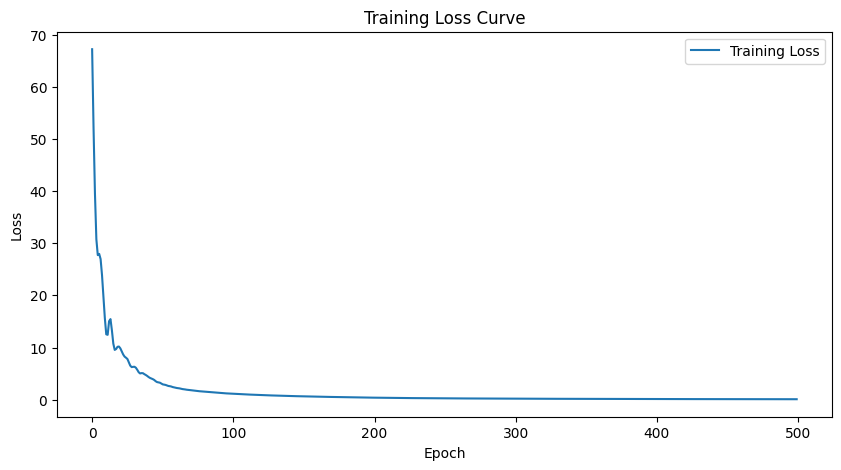

Final Model Accuracy: 56.28%


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_layer_TSNE3_TSNE2.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

/tmp/ipykernel_3361873/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.55      0.59      0.57       283
non_infringement       0.58      0.53      0.56       298

        accuracy                           0.56       581
       macro avg       0.56      0.56      0.56       581
    weighted avg       0.56      0.56      0.56       581

